In [1]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplers import MetropolisHastingsSampler


import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:

model = MLP(layer_dims=[1,2,1])
model.to(device)
print(model)

MLP(input_dim=1, output_dim=1, hidden_dims=[2], activation=tanh)


In [3]:
class TestHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return -torch.exp(-x**2)
    
hamiltonian = TestHamiltonian(model=model)
hamiltonian.to(device)
print(hamiltonian(torch.tensor([2.0], device=device))) # check that the hamiltonian is working

tensor([-0.0183], device='cuda:0')


Sample mean: -0.0361
Sample std: 0.9751


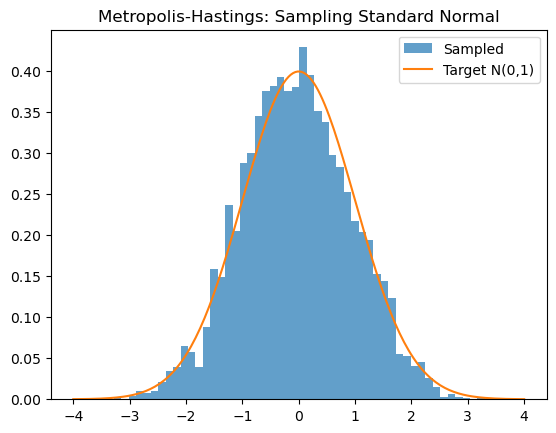

In [4]:
# Simple harmonic oscillator: E(x) = 0.5 * x^2
class HarmonicHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return 0.5 * x.pow(2).sum(dim=-1)

# Your sampler
sampler = MetropolisHastingsSampler(
    model=HarmonicHamiltonian(),
    n_samples=5000,
    step_size=0.5,
    burn_in=500,
    is_wf=False,
)

sampler.to(device)

# Initial point
x0 = torch.tensor([0.0], device=device)

# Run sampler
samples = sampler(x0)
samples_np = samples.cpu().detach().numpy().flatten()

# Statistics
mean = samples_np.mean()
std = samples_np.std()

print(f"Sample mean: {mean:.4f}")
print(f"Sample std: {std:.4f}")

# Histogram
plt.hist(samples_np, bins=50, density=True, alpha=0.7, label='Sampled')
xs = torch.linspace(-4, 4, 200)
plt.plot(xs, torch.exp(-0.5 * xs**2) / (2 * torch.pi)**0.5, label='Target N(0,1)')
plt.legend()
plt.title("Metropolis-Hastings: Sampling Standard Normal")
plt.show()

In [5]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def V(x):
    return 0.5 * x**2

In [6]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

In [163]:
epochs = 10000

Nh=30

model = MLP(layer_dims=[1, Nh, 1], activation="tanh")
model.to(device)

with torch.no_grad():
    for param in model.parameters():
        if param.dim() > 1:  # Only initialize weights, not biases
            nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

energies = []
losses = []

L_BOX = 2.0

x_train = torch.linspace(-L_BOX/2, L_BOX/2, 10000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-2)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    # V_psi = V(x_train) * psi
    H_psi = T #+ V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy
    energies.append(energy.item())

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss += 1e3 * (psi[0]**2 + psi[-1]**2) # penalize boundary conditions
    
    # loss += 1e8 * (model(torch.tensor([-L_BOX/2], device=device))**2+ model(torch.tensor([L_BOX/2], device=device))**2).sum()
    losses.append(loss.item())
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
print(energy)
# model.load_state_dict(callback.best_model_state)
# energy = callback.best_energy
# print(f"Best energy found: {energy.item():.4f}")

model parameters:
model.0.weight torch.Size([30, 1])
model.0.bias torch.Size([30])
model.2.weight torch.Size([1, 30])
model.2.bias torch.Size([1])
Epoch 1/10000, Loss: 2947.0901, Energy: 0.0301
Epoch 101/10000, Loss: 1184.5822, Energy: -0.0819
Epoch 201/10000, Loss: 1081.1597, Energy: -0.0490
Epoch 301/10000, Loss: 1033.9431, Energy: -0.0210
Epoch 401/10000, Loss: 997.5632, Energy: 0.0036
Epoch 501/10000, Loss: 962.4840, Energy: 0.0285
Epoch 601/10000, Loss: 921.8279, Energy: 0.0579
Epoch 701/10000, Loss: 863.0280, Energy: 0.1012
Epoch 801/10000, Loss: 715.8526, Energy: 0.2143
Epoch 901/10000, Loss: 1.2877, Energy: 1.2311
Epoch 1001/10000, Loss: 1.2384, Energy: 1.2380
Epoch 1101/10000, Loss: 1.2384, Energy: 1.2381
Epoch 1201/10000, Loss: 1.2384, Energy: 1.2381
Epoch 1301/10000, Loss: 1.2384, Energy: 1.2381
Epoch 1401/10000, Loss: 1.2384, Energy: 1.2381
Stopping training after 1424 epochs due to no improvement in energy.
Training stopped early at epoch 1424
tensor([1.2384], device='cuda

In [164]:
def analytic_wf(x,n):
    if n%2 == 0:
        return (2/L_BOX)**0.5 * torch.sin(x*n * torch.pi /L_BOX )
    else:
        return (2/L_BOX)**0.5 * torch.cos(x*n * torch.pi / L_BOX)
    
def analytic_energy(n):
    return (n * torch.pi / L_BOX)**2 / 2

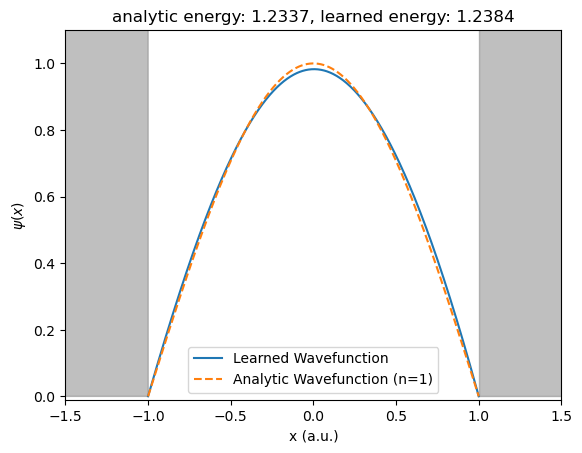

In [165]:
normalization = torch.trapezoid(psi.pow(2), x_train, dim=0)
import numpy as np
if psi[len(psi)//2] < 0:
    psi = -psi  # ensure positive wavefunction at center
plt.plot(x_train.cpu().detach().numpy(), psi.cpu().detach().numpy(), label='Learned Wavefunction')
plt.plot(x_train.cpu().detach().numpy(), analytic_wf(x_train, 1).cpu().detach().numpy(), label='Analytic Wavefunction (n=1)', linestyle='--')
plt.title(f"analytic energy: {analytic_energy(1):.4f}, learned energy: {energy.item():.4f}")
plt.xlabel("x (a.u.)")
plt.ylabel(r"$\psi(x)$")
x = np.linspace(-L_BOX, L_BOX, 1000)  # centered around 0
plt.fill_between(x, 0, 10.0, where=(x >= 1) & (x <= 2), color='gray', alpha=0.5, interpolate=True)
plt.fill_between(x, 0, 10.0, where=(x >= -2) & (x <= -1), color='gray', alpha=0.5, interpolate=True)
plt.xlim(-(L_BOX/2+0.5), L_BOX/2+0.5)
plt.ylim(-0.01, 1.1)
plt.legend();

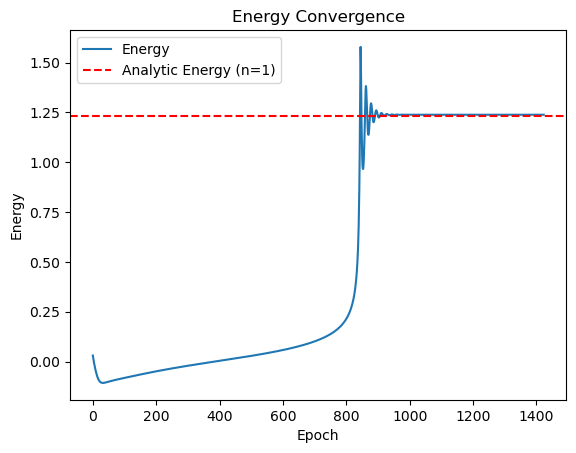

In [169]:
plt.plot(energies, label='Energy')
# plt.plot(losses, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Energy Convergence")
plt.axhline(analytic_energy(1), color='red', linestyle='--', label='Analytic Energy (n=1)')
plt.legend()

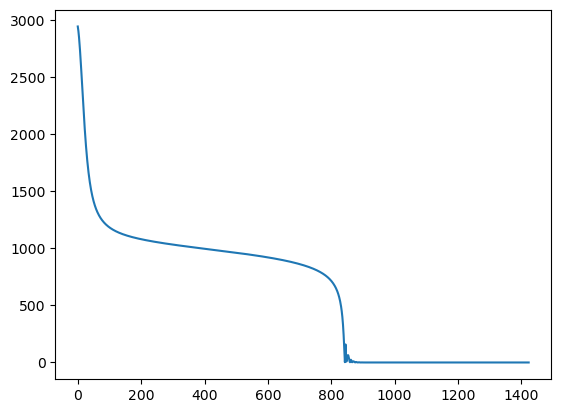

In [167]:
plot = [l-e for l, e in zip(losses, energies)]
plt.plot(plot, label='Loss - Energy')

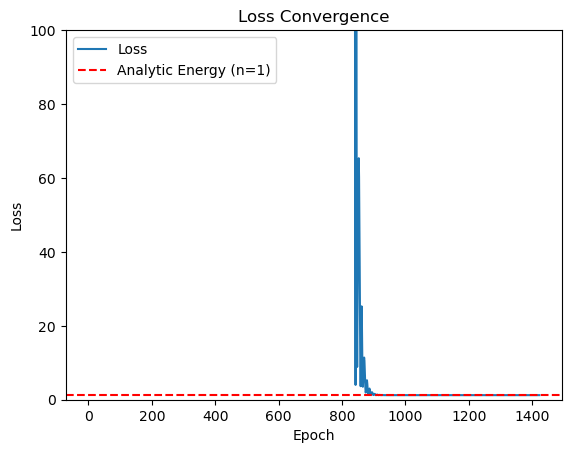

In [168]:
plt.plot(losses, label='Loss')
plt.axhline(analytic_energy(1), color='red', linestyle='--', label='Analytic Energy (n=1)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.ylim(0, 100)
plt.legend()


In [294]:
epochs = 10000

Nh=60

model = MLP(layer_dims=[1, Nh,Nh, 1], activation="tanh")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

L_BOX = 20.0

x_train = torch.linspace(-L_BOX/2, L_BOX/2, 10000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-5)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    V_psi = V(x_train) * psi
    H_psi = T + V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    # psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    # loss += 1e6 * (psi[0]**2 + psi[-1]**2) # penalize boundary conditions
    
    # loss += 1e8 * (model(torch.tensor([-L_BOX/2], device=device))**2+ model(torch.tensor([L_BOX/2], device=device))**2).sum()
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
print(energy)
model.load_state_dict(callback.best_model_state)

model parameters:
model.0.weight torch.Size([60, 1])
model.0.bias torch.Size([60])
model.2.weight torch.Size([60, 60])
model.2.bias torch.Size([60])
model.4.weight torch.Size([1, 60])
model.4.bias torch.Size([1])
Epoch 1/10000, Loss: 14.3484, Energy: 14.3484
Epoch 101/10000, Loss: 4.5672, Energy: 4.5672
Epoch 201/10000, Loss: 1.7771, Energy: 1.7771
Epoch 301/10000, Loss: 0.8085, Energy: 0.8085
Epoch 401/10000, Loss: 0.6198, Energy: 0.6198
Epoch 501/10000, Loss: 0.5482, Energy: 0.5482
Epoch 601/10000, Loss: 0.5220, Energy: 0.5220
Epoch 701/10000, Loss: 0.5140, Energy: 0.5140
Epoch 801/10000, Loss: 0.5113, Energy: 0.5113
Epoch 901/10000, Loss: 0.5098, Energy: 0.5098
Epoch 1001/10000, Loss: 0.5087, Energy: 0.5087
Epoch 1101/10000, Loss: 0.5078, Energy: 0.5078
Epoch 1201/10000, Loss: 0.5070, Energy: 0.5070
Epoch 1301/10000, Loss: 0.5063, Energy: 0.5063
Epoch 1401/10000, Loss: 0.5057, Energy: 0.5057
Epoch 1501/10000, Loss: 0.5051, Energy: 0.5051
Epoch 1601/10000, Loss: 0.5047, Energy: 0.504

<All keys matched successfully>

Normalization constant: 3.976738452911377


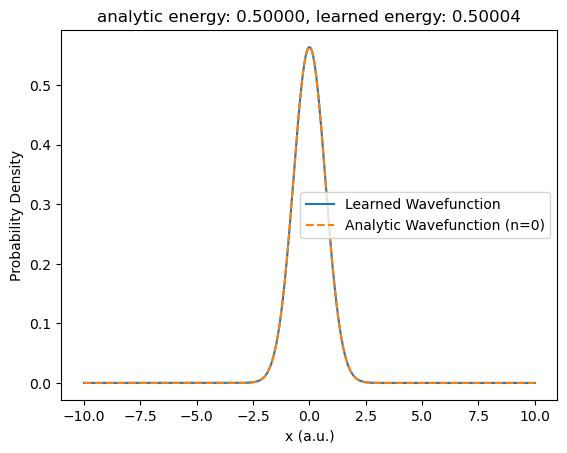

In [302]:
from scipy.special import hermite
from scipy.special import factorial
import numpy as np

def exact_solution(x,n):
        hermite_poly = hermite(n)
        coeff = np.sqrt(1 / (2**n * factorial(n))) * (1 / np.pi)**0.25
        return coeff * np.exp(-0.5*x**2) * hermite_poly(x)
    
def exact_energy(n):
    return n + 0.5

normalization = torch.trapezoid(psi.pow(2), x_train, dim=0)
print(f"Normalization constant: {normalization.item()}")
psi_normalized = psi / torch.sqrt(normalization + 1e-8)  # normalize wavefunction

plt.plot(x_train.cpu().detach().numpy(), psi_normalized.pow(2).cpu().detach().numpy(), label='Learned Wavefunction')
plt.plot(x_train.cpu().detach().numpy(), exact_solution(x_train.cpu().detach().numpy(), 0)**2, label='Analytic Wavefunction (n=0)', linestyle='--')
plt.title(f"analytic energy: {exact_energy(0):.5f}, learned energy: {energy.item():.5f}")
plt.xlabel("x (a.u.)")
plt.ylabel("Probability Density")
plt.legend();

# Sampler stuff

In [ ]:
from tqdm import tqdm
epochs = 10000

model = MLP(layer_dims=[1, 60, 1])
model.to(device)

hamiltonian = HarmonicOscillator(model=model)

hamiltonian.to(device)

sampler = MetropolisHastingsSampler(
    model=model,copy()
"""

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

x_train = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

samples = torch.randn(10000, 1).to(device)
samples.requires_grad = True

trapezoid = True

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    # Run sampler
    if not trapezoid:
        x0 = torch.randn(1).to(device)
        samples = sampler(x0)
        samples.requires_grad = True

        # Compute the mean and std of the local energy
        local_energy = hamiltonian(samples)
        psi = model(samples)
        energy = local_energy.mean().item()
        energy_std = local_energy.std().item()
        loss = local_energy.mean()

    if trapezoid:
        psi = model(x_train) # computes forward pass
        T = kinetic_energy(psi, x_train)
        # V_psi = V(x_train) * psi
        H_psi = T #+ V_psi

        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
        energy = numerator / denominator
        loss = energy
    else:
        mask = torch.abs(samples.squeeze()) > 3  # shape: (batch_size,)
        loss += 1e2 * (psi[mask]**2).sum()

    # boundary conditions
    loss += 1e-2 * (psi[0]**2+ psi[-1]**2).sum()
    
    loss.squeeze().backward()
    optimizer.step()
    
print(energy)
final_model = model
final_model.load_state_dict(callback.best_model_state)

model parameters:
model.0.weight torch.Size([60, 1])
model.0.bias torch.Size([60])
model.2.weight torch.Size([1, 60])
model.2.bias torch.Size([1])


100%|██████████| 10000/10000 [00:15<00:00, 656.85it/s]

tensor([-16.8295], device='cuda:0', grad_fn=<AddBackward0>)


AttributeError: 'MLP' object has no attribute 'copy'

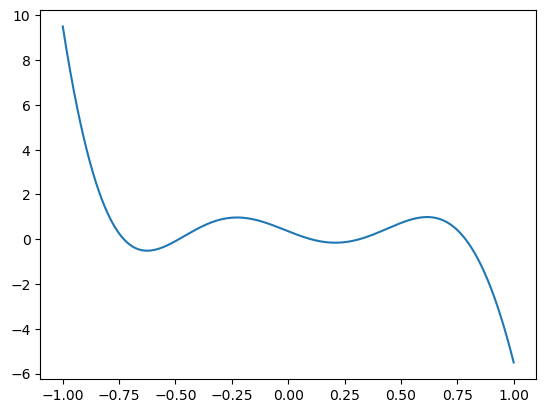

In [50]:
x = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
x_cpu = (x.cpu().detach().numpy())
y = model(x)
normalization_model = torch.trapezoid(y, x, dim=0)
y_cpu = (model(x)/normalization_model).cpu().detach().numpy()
import numpy as np
def analytic_solution(x):
    return np.exp(-0.5 * x**2) / (2 * np.pi)**0.5

plt.plot(x_cpu, y_cpu, label='Sampled')
# plt.plot(x_cpu, analytic_solution(x_cpu), label='Target N(0,1)')